In [3]:
import pymc as pm
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [38]:
import matplotlib.pyplot as plt

# Problem Set Up

We're going to set up a ds problem using the same generative model that we're going to solve it with. This means if we do things right, we should have a really good shot of going "backwards" from our data to discovering the model parameters that created it. Let's try it, and see if it works!

The basic problem is a change point detection problem (in the number of counts per day that we see of something we're measuring). We want to know where the shift in behavior happened from one poisson distribution to another.

following here:
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb

which stems from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers 



In [81]:
# gen data

np.random.seed(12)

count_data_1 = np.random.poisson(10, 50)
count_data_2 = np.random.poisson(30,20)
count_data = np.concatenate((count_data_1, count_data_2))
count_data
n_count_data = len(count_data)

In [82]:
count_data

array([ 6,  8, 15, 17,  8, 16, 10, 13, 13,  6,  8, 10,  8, 12,  9,  9, 10,
       10,  5, 11,  8,  9, 11,  5, 11, 10, 15, 11, 10, 11, 16, 11,  8, 18,
       12,  9, 11,  8,  7,  9, 14,  9, 10, 13,  7, 13,  6,  8, 12,  9, 24,
       21, 39, 27, 30, 28, 32, 23, 32, 27, 32, 33, 26, 32, 28, 34, 39, 29,
       35, 32])

^ we have some data! we've set it so there really are two processes here, and the transition point occurs at t=51

In [83]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean() # prior guess for alpha is the inverse of the mean of our data

    # think about how we would generate a hypothetical instance of this data
    lambda_1 = pm.Exponential("lambda_1", alpha) # draw a lambda_1 from our distbution
    lambda_2 = pm.Exponential("lambda_2", alpha) # draw a second lambda we'll use after our switchpoint
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1) # we generate a random switchpoint from a discrete uniform

In [84]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) # create a lambda composed of lambda_1 and lambda_2

In [85]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)


let's look at our model (model object attributes can be found here: https://www.pymc.io/projects/docs/en/v5.10.2/api/model/generated/pymc.model.core.Model.html)

In [86]:
model.basic_RVs

[lambda_1 ~ Exponential(f()),
 lambda_2 ~ Exponential(f()),
 tau ~ DiscreteUniform(f(), f()),
 obs ~ Poisson(f(lambda_1, lambda_2, tau))]

In [87]:
pm.draw(model.tau) # drawn from prior!

array(59)

In [88]:
pm.draw(lambda_1) # drawn from prior!

array(6.33751498)

In [89]:
pm.draw(observation) # drawn from prior!

array([ 0, 15, 23, 24, 23, 27, 19, 18, 18, 26, 20, 30, 24, 24, 29, 20, 25,
       20, 22, 26, 24, 26, 24, 17, 17, 26, 16, 22, 28, 26, 25, 25, 23, 13,
       22, 25, 16, 25, 22, 27, 13, 23, 22, 22, 18, 23, 15, 26, 17, 28, 12,
       17, 24, 20, 22, 22, 31, 20, 14, 16, 21, 27, 22, 17, 17, 26, 14, 20,
       17, 14])

ok! let's fit our model!

In [90]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 4 seconds.


In [91]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [92]:
tau_samples # nailed it immediately!

array([50, 50, 50, ..., 50, 50, 50])

# Results 

(Analysis below)
The model totally nailed the right value for tau! It started at 50 and pretty much stuck there, dipping down to 49 a little.
Posterior estimates for lambda 2 were wider than lambda 1, and that makes sense because we had 20 datapoints in the lambda = 30 range and 50 datapoints in the lambda = 10 range. Still, overall our inference totally got the right answer!

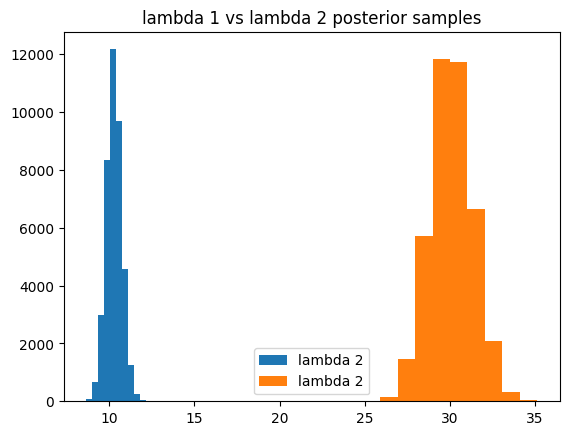

In [93]:
plt.title('lambda 1 vs lambda 2 posterior samples')
plt.hist(lambda_1_samples, label='lambda 2')
plt.hist(lambda_2_samples, label='lambda 2')
plt.legend()

In [94]:
np.min(tau_samples)

49

In [95]:
np.max(tau_samples)

52

In [96]:
np.mean(tau_samples==50) # almost always 50

0.9961

# Expectations

The tutorial we're following does a really cool trick next that I'll replicate. The question is simple: what does the expected value for the number of texts per day look like?

They do a great job coding up the solution but I think the explanation is even more beautiful than they give it credit for. Reading it, I was reminded once of a conversation I had with a colleague, where he told me that his modeling approach is just to ask: what kind of least complicated model could plausibly generate the data? Of course the priors on the model are uncalibrated, but after fitting on the data, what do we have? If you have a set of parameters, you've got a way of generating a world! For example, you can generate a single chain set of observations equivalent in shape to the original data we had. From that same set of parameters, you can generate multiple such sets of observations. But one set of parameters sampled from our posterior doesn't represent our state of knowledge of the kind of generative process that made the world the real data are from. If it did, our posteriors would just be dirac delta's at those values. So the way to generate one single instance of data from our data generating process is to sample a set of parameters from our distributions, and then sample a set of observations from our parameters. And that's one set of observations. To get the expectated value of our observations, we take many sets of observations and then average over them. If we want an average per time value, we draw sets of time series and then average the values across the many time series, at each time value!

There's a special hack for this model though: we don't need to draw data observations, because for a poisson process the mean is the mean
of the parameter! So instead of drawing observations, it's sufficient to draw sets of parameters plus switchpoints, and from there generate sets of time series of expected values. We then average over all those time series. We'll do that instead!


In [97]:
means_list = []
for t_i in range(0, len(count_data)):
    idx = t_i < tau_samples
    lambda_i = np.append(lambda_1_samples[idx], lambda_2_samples[~idx])
    mean_i = np.mean(lambda_i)
    means_list.append(mean_i)
    

Text(0.5, 1.0, 'Modeled Expected Values vs Original Data')

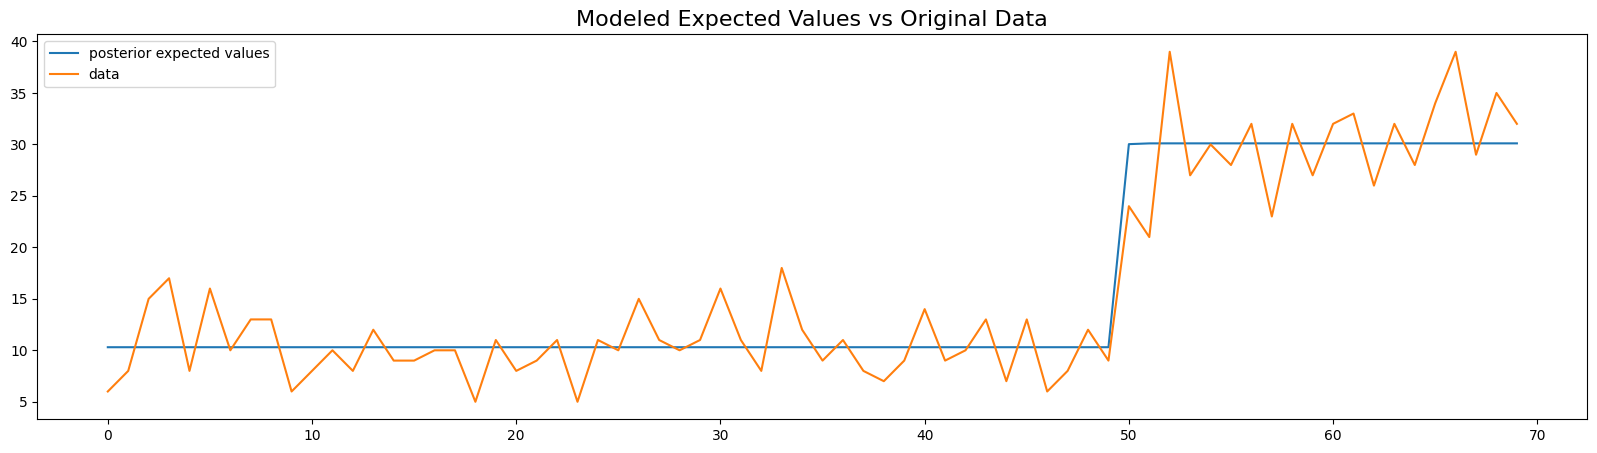

In [103]:
plt.figure(figsize=(20,5))
plt.plot(means_list, label="posterior expected values")
plt.plot(count_data, label="data")
plt.legend()
plt.title("Modeled Expected Values vs Original Data", size=16)

# Conclusion

Wow, looking good! Our expectation tracks really well with the data. We were able to fit it well. That's not a huge surprise given that we had the advantage of using the same structure that the actual data generating process used. But it's still a great demonstration that our structure, plus the data, plus bayesian technology was able to recover the parameters we originally used and all is well.